# Verifying a finite element solver for the steady convection-diffusion equation using FEniCS and the Method of Manufactured Solution.

This tutorial summarizes how to...
- solve the steady convection-diffusion equation [1] with FEniCS [2].
- verify a solver via the Method of Manufactured Solution (MMS) [3].

## Python packages

Show version info for the Python system running this notebook server.

In [1]:
import sys
print("Using Python " + sys.version)

Using Python 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


Use the FEniCS library to implement the solver and also for post-processing. We also import the back-end `dolfin` because there seems to be no other way to show the version number.

In [2]:
import fenics
import dolfin
print("Using fenics-" + dolfin.__version__)

Using fenics-2018.1.0


Typically FEniCS users don't directly use UFL; but we will need one feature to apply MMS with vector-valued solutions.

In [3]:
from ufl import unit_vector

We have to do a bit of arithmetic to compute the empirical order of convergence.

In [4]:
import math

Though `fenics` has the built-in `fenics.plot`, we will do some more advanced plotting.

In [5]:
import matplotlib
print("Using matplotlib-" + matplotlib.__version__)
%matplotlib inline

Using matplotlib-3.0.1


## The problem

Consider the strong form of the steady convection-diffusion equation.

\begin{align*} 
    \mathbf{a}\cdot\nabla u - \nabla \cdot \left(\nu\nabla u\right) &= s
\end{align*}

Applying the standard Ritz-Galerkin finite element method and assuming homogeneous Neumann boundary conditions, we solve the equivalent variational problem:
Find $u \in V$ such that

\begin{align*}
    \left(w, \mathbf{a} \cdot \nabla u\right) + \left(\nabla w, \nu \nabla u \right) = \left(w , s\right) \forall w \in V
\end{align*}

where for space $V$ we can for example choose the space of piece-wise linear functions.

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

## The solver

The following class solves this variational problem for a general mesh, velocity field, viscosity, source field, and boundary conditions.

In [6]:
class ConvectionDiffusionModel:
    
    def __init__(self, 
            mesh, velocity, viscosity, source_term, boundary_value):
        
        function_space = fenics.FunctionSpace(
            mesh, fenics.FiniteElement('P', mesh.ufl_cell(), 1))
        
        solution = fenics.Function(function_space)
        
        boundary_conditions = fenics.DirichletBC(
            function_space, boundary_value, "on_boundary")
        
        a, nu, s = velocity, viscosity, source_term
        
        """ Symbolic vector fields in `fenics` use unit vectors. """
        ihat, jhat = unit_vector(0, 2), unit_vector(1, 2)

        _a = a[0]*ihat + a[1]*jhat
    
        u = fenics.TrialFunction(function_space)
        
        w = fenics.TestFunction(function_space)
        
        dot, grad = fenics.dot, fenics.grad
        
        problem = fenics.LinearVariationalProblem(
            (w*dot(_a, grad(u)) + dot(grad(w), nu*grad(u)))*fenics.dx,
            w*s*fenics.dx,
            solution,
            bcs = boundary_conditions)
        
        solver = fenics.LinearVariationalSolver(problem)
        
        self.solution = solution
        
        self.solver = solver
        
        """ Patch: A scoping issue requires us to make bc's an attribute. """
        self.boundary_conditions = boundary_conditions

## Verification via MMS

Manufacture a solution according to the guidelines in [3]. The syntax of `fenics` requires us to define this in terms of a mesh to access the spatial coordinates.

In [7]:
def manufactured_solution(mesh):
    
    sin, pi = fenics.sin, fenics.pi
    
    x = fenics.SpatialCoordinate(mesh)
    
    return sin(2.*pi*x[0])*sin(pi*x[1])

Derive the source terms which will yield the manufactured solution
    by substituting the manufactured solution into the strong form.

In [8]:
def source_term(manufactured_solution, velocity, viscosity):
    
    dot, grad, div = fenics.dot, fenics.grad, fenics.div
    
    u = manufactured_solution
    
    a, nu = velocity, viscosity
    
    """ Symbolic vector fields in `fenics` use unit vectors. """
    ihat, jhat = unit_vector(0, 2), unit_vector(1, 2)
    
    _a = a[0]*ihat + a[1]*jhat
    
    return dot(_a, grad(u)) - div(nu*grad(u))

Compute the L2 norm error based on the manufactured solution and the computed discrete solution.

In [9]:
def L2_error(manufactured_solution, computed_solution):
    
    u_m, u_h = manufactured_solution, computed_solution
    
    return math.sqrt(fenics.assemble((u_h - u_m)**2*fenics.dx))

Define a function for plotting the solution.

In [10]:
def plot(solution):
    
    colormap = fenics.plot(solution)

    matplotlib.pyplot.colorbar(colormap)

    matplotlib.pyplot.title("$u$")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$y$")

    matplotlib.pyplot.show()

Solve a series of problems with larger grids to verify the convergence order. Plot the L2 errors against the cell edge lengths with a log-log scale. Also print the computed empircal convergence order. We expect to see quadratic convergence.

|Note| 
|----|
|The minimum error will be on the order of $\gamma$, i.e. the stabilized method is not exactly consistent.|

In [11]:
def run_convergence_study(grid_sizes = (1, 2, 4, 8, 16, 32, 64)):
    
    L2_errors = []

    sin, pi = fenics.sin, fenics.pi
    
    nu = 0.1
    
    for M in grid_sizes:

        mesh = fenics.UnitSquareMesh(M, M)
        
        x = fenics.SpatialCoordinate(mesh)

        a = (sin(2.*pi*x[0])*sin(4.*pi*x[1]), sin(pi*x[0])*sin(2.*pi*x[1]))
        
        u_m = manufactured_solution(mesh)
        
        model = ConvectionDiffusionModel(
            mesh = mesh,
            velocity = a,
            viscosity = nu,
            source_term = source_term(u_m, a, nu),
            boundary_value = u_m)

        model.solver.solve()

        plot(model.solution)

        L2_errors.append(L2_error(manufactured_solution(mesh), model.solution))
        
    edge_lengths = [1./float(M) for M in grid_sizes]
    
    matplotlib.pyplot.loglog(edge_lengths, L2_errors)
    
    matplotlib.pyplot.xlabel("$h$")
    
    matplotlib.pyplot.ylabel("$L^2$ error")
    
    matplotlib.pyplot.axis("square")
    
    e, h = L2_errors, edge_lengths
    
    log = math.log
    
    orders = [(log(e[i + 1]) - log(e[i]))/(log(h[i + 1]) - log(h[i]))
              for i in range(len(e) - 1)]
    
    print("Convergence orders = " + str(orders))

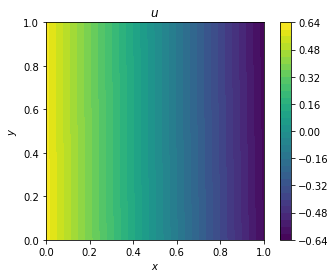

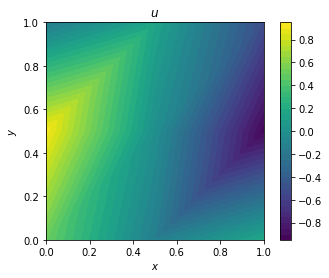

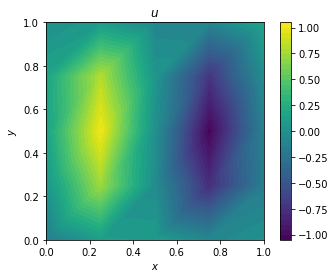

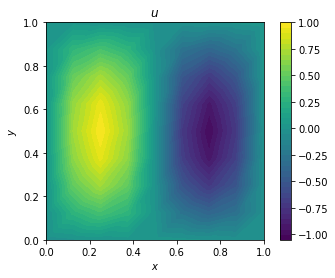

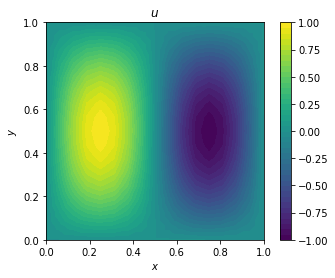

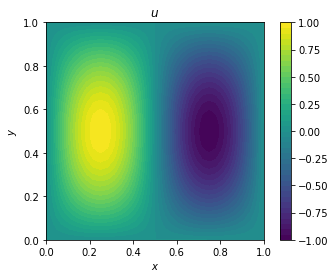

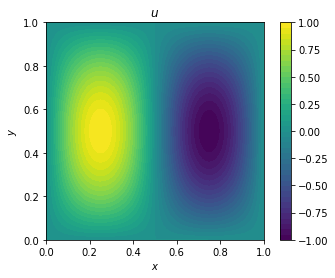

Convergence orders = [0.1910480407674884, 1.575225448038292, 1.6372222757939083, 1.90963049736213, 1.965141666399798, 1.9841833267895383]


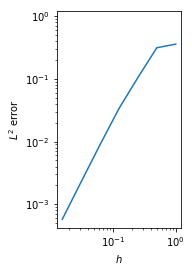

In [12]:
run_convergence_study()

## References
[1] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003.

[2] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[3] K Salari and P Knupp. **Code verification by the method of manufactured solutions.**, *Sandia National Labs*, No. SAND2000-1444, 2000.